### Plots for logit based

In [42]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import numpy as np
from sklearn.metrics import roc_auc_score
import seaborn as sns

import numpy as np

df_results = pd.read_csv("./processed_csvs/classification.csv")


def convert_to_float_list(string_list):
    return [float(x) for x in string_list.strip("[]").split(", ")]


# Apply the function to the 'probabilities' column
df_results["probabilities"] = df_results["probabilities"].apply(convert_to_float_list)
df_results["positive_probabilities"] = [p[1] for p in df_results["probabilities"]]
all_datasets = df_results["dataset"].unique()
all_models = df_results["model"].unique()
all_annotators = df_results["annotator"].unique()
df_results = df_results.sort_values(by=["dataset", "model", "annotator"])
all_auroc = []

df_list = []

for dataset in all_datasets:
    for model in all_models:
        for annotator in all_annotators:
            df = df_results[
                (df_results["dataset"] == dataset)
                & (df_results["model"] == model)
                & (df_results["annotator"] == annotator)
            ].copy()
            labels = df["gold_class"].unique()
            auroc = roc_auc_score(df["gold_class"], df["positive_probabilities"])
            df["auroc"] = auroc
            df_list.append(df)

df_results = pd.concat(df_list)
df_results = df_results.drop(["instance", "probabilities"], axis=1)

df_results_grouped = (
    df_results.groupby(["task_type", "dataset", "model", "annotator"])
    .mean()
    .reset_index()
)

df_results_grouped = df_results_grouped[["dataset", "model", "annotator", "auroc"]]
# create a new column called annot_ranking that ranks the annotators based on their auroc within a subgroup
# defined by dataset and model.

df_results_grouped["annot_ranking"] = (
    df_results_grouped.groupby(["dataset", "model"])["auroc"]
    .rank(ascending=False)
    .astype(int)
)

df_results_grouped_og = df_results_grouped.copy()

In [43]:
DATASET_MAP = {
    "asthma_classification": "Obesity Co-Morb. (Ast.)",
    "cohort_alcohol_abuse_classification": "Cohort Alcohol Abuse",
    "cad_classification": "Obesity Co-Morb. (CAD)",
    "cohort_drug_abuse_classification": "Cohort Drug Abuse",
    "cohort_english_classification": "Cohort English",
    "cohort_make_decisions_classification": "Cohort Make Decisions",
    "cohort_abdominal_classification": "Cohort Abdominal",
    "diabetes_mellitus_classification": "Obesity Co-Morb. (DM)",
    "obesity_classification": "Obesity",
    "mimic_mortality_prediction": "Mimic Mortality Pred.",
}


def rename_annotator(name):
    return name.replace("Annotator_", "Expert ")

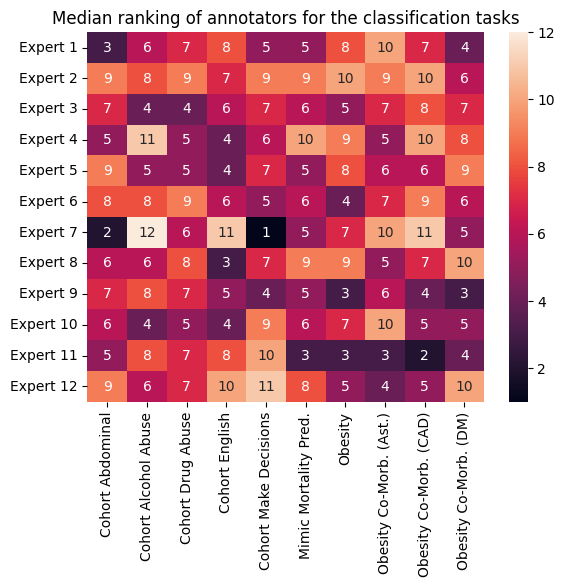

In [45]:
df = df_results_grouped_og.copy()
datasets = df["dataset"].unique()
# get a dataframe with the median ranking for each annotator for every dataset

df = df.groupby(["annotator", "dataset"])["annot_ranking"].median().reset_index()
df["dataset"] = df["dataset"].map(DATASET_MAP)
df["annotator"] = df["annotator"].map(rename_annotator)
# order annotator by the number at the end of the string
df["annotator_order"] = df["annotator"].apply(lambda x: int(x.split(" ")[-1]))
df = df.sort_values(by=["dataset", "annotator_order"])

df = df.pivot(index="annotator", columns="dataset", values="annot_ranking")

experts = [f"Expert {i}" for i in range(1, 13)]
# use experts variable as a categorical sorter for the rows in df

df = df.loc[experts]

# plot a heatmap where each row is a model and each column is an annotator, the values should be defined by auroc

sns.heatmap(df, annot=True)
plt.title("Median ranking of annotators for the classification tasks")
# rotate the y ticks
plt.xticks(rotation=90)
plt.ylabel("")
plt.xlabel("")
plt.savefig("consistency_classification.pdf", bbox_inches="tight")

# EXTRACTION

In [32]:
df_results_grouped_extraction = pd.read_csv(
    "./processed_csvs/extraction_grouped.csv"
).drop(columns=["Unnamed: 0"])
df_results_grouped_extraction = df_results_grouped_extraction.rename(
    columns={"f1_score": "F1"}
)
df_results_grouped = pd.concat(
    [df_results_grouped, df_results_grouped_extraction], axis=0
)

df_results_grouped_extraction["model"].unique()

array(['mistral-7b', 'Llama-2-13b-chat', 'Llama-2-7b-chat-hf',
       'alpaca-7b', 'clinical-camel-7b', 'asclepius', 'medalpaca-7b'],
      dtype=object)

In [38]:
DATASET_MAP = {
    "drug_extraction": "Drug Ext.",
    "medication_extraction": "Medication Ext.",
    "concept_treatment_extraction": "Concept Treatment Ext.",
    "concept_problem_extraction": "Concept Problem Ext.",
    "concept_test_extraction": "Concept Test Ext.",
    "risk_factor_cad_extraction": "Risk Factor CAD Ext.",
}


def rename_annotator(name):
    return name.replace("Annotator_", "Expert ")

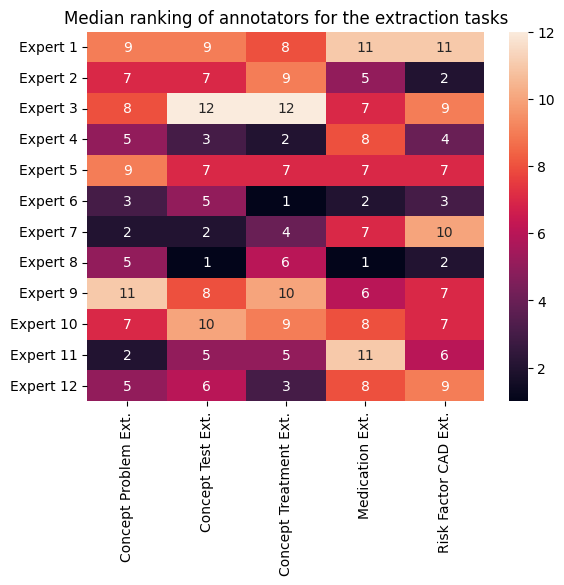

In [41]:
df = df_results_grouped_og.copy()
datasets = df["dataset"].unique()
# get a dataframe with the median ranking for each annotator for every dataset

df = df.groupby(["annotator", "dataset"])["annot_ranking"].median().reset_index()
df["dataset"] = df["dataset"].map(DATASET_MAP)
df["annotator"] = df["annotator"].map(rename_annotator)
# order annotator by the number at the end of the string
df["annotator_order"] = df["annotator"].apply(lambda x: int(x.split(" ")[-1]))
df = df.sort_values(by=["dataset", "annotator_order"])

df = df.pivot(index="annotator", columns="dataset", values="annot_ranking")

experts = [f"Expert {i}" for i in range(1, 13)]
# use experts variable as a categorical sorter for the rows in df

df = df.loc[experts]

# plot a heatmap where each row is a model and each column is an annotator, the values should be defined by auroc

sns.heatmap(df, annot=True)
plt.title("Median ranking of annotators for the extraction tasks")
# rotate the y ticks
plt.xticks(rotation=90)
plt.ylabel("")
plt.xlabel("")
plt.savefig("consistency_extraction.pdf", bbox_inches="tight")